# Clustering neighborhoods in New Orleans via the Foursquare API

We cluster neighborhoods in New Orleans, as identified from Wikipedia, relative to the frequencies of venue categories in each neighborhood as determined by calls to the Foursquare Places API.  The clustering is performed by using SciKit-Learn's k-means clustering algorithm on a OneHot encoding of the above data.  We particularly wish to identify those neighborhoods similar in character to the popular French Quarter in downtown New Orleans.

This analysis was performed on 5 March, 2021; by nature of the Foursquare API, it is possible that the data (and the corresponding analysis) may change in the future.

## Part 1: Scrape Wikipedia for NOLA Neighborhoods

In [1]:
#Import relavant packages

import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

import lxml.html as lh # library to handle html parsing

#!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans
#!conda install -c conda-forge folium=0.5.0 --yes
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


In [2]:
#A few more packages to import.

from sklearn import metrics
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt

In [3]:
#Establish datascraping url
url = 'https://en.wikipedia.org/wiki/Neighborhoods_in_New_Orleans'

#Create a handle, page, to handle the contents of the website
page = requests.get(url)

#Store the contents of the website under doc
doc = lh.fromstring(page.content)

Everything in the table on wikipedia is between <tr> and </tr> markers in html; let's extract this info.

In [4]:
#Parse data that are stored between <tr>..</tr> of HTML
tr_elements = doc.xpath('//tr')

#Verify that tr_elements rows have same length
#[len(T) for T in tr_elements[:]]

Looks like the last seven rows of our data tr_elements are from other tables; let's drop them.

In [5]:
tr_elements = tr_elements[:len(tr_elements)-7]

#[len(T) for T in tr_elements[:]]

Let's see what we've scraped:

In [6]:
#Check the output of the first row
tr_elements[0].text_content()

'\nNeighborhood\n\nLongitude\n\nLatitude\n'

We will now scrape the information in the table.

In [7]:
#Create empty list
col=[]
i=0
#For each row, store each first element (header) and an empty list
for t in tr_elements[0]:
    i+=1
    #Extract text content from each row element, removing the extra line break \n.
    name=t.text_content().replace('\n','')
    print('%d:"%s"'%(i,name))
    col.append((name,[]))

1:"Neighborhood"
2:"Longitude"
3:"Latitude"


In [8]:
for j in range(1,len(tr_elements)):
    #T is our jth row
    T=tr_elements[j]
    
    #i is the index of our column
    i=0
    
    #Iterate through each element of the row
    for t in T.iterchildren():
        data=t.text_content().replace('\n','')
        #Append the data to the empty list of the i'th column
        col[i][1].append(data)
        #Increment i for the next column
        i+=1

Now let's convert the data col into a dictionary, and then into a dataframe.

In [9]:
Dict={title:column for (title,column) in col}
df=pd.DataFrame(Dict)

In [10]:
df

,Neighborhood,Longitude,Latitude
0,U.S. NAVAL BASE,-90.02609253,29.94608469
1,ALGIERS POINT,-90.0516057,29.95246187
2,WHITNEY,-90.04235744,29.94720026
3,AUDUBON,-90.12145042,29.93299437
4,OLD AURORA,-90,29.92444011
5,B. W. COOPER,-90.09175301,29.95177397
6,BAYOU ST. JOHN,-90.08651733,29.97607064
7,BEHRMAN,-90.02643585,29.9348167
8,BLACK PEARL,-90.13488293,29.93589521
9,BROADMOOR,-90.10381222,29.9465681


In [11]:
df.shape

(72, 3)

We need to ensure that the coordinate data are floats rather than strings:

In [12]:
df['Latitude'] = df['Latitude'].astype(float)
df['Longitude'] = df['Longitude'].astype(float)

## Part 2: Explore and cluster NOLA neighborhoods

Find the central latitude and longitude for NOLA:

In [13]:
address = 'New Orleans, Louisiana, United States'

#Find the latitude and longitude coordinates of the address above.
geolocator = Nominatim(user_agent="toronto_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geographical coordinates of New Orleans are {}, {}.'.format(latitude, longitude))

The geographical coordinates of New Orleans are 29.9499323, -90.0701156.


Create a map of NOLA with our neighborhoods superimposed on top:

In [14]:
# create map of New Orleans using latitude and longitude values
map_NOLA = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, neighborhood in zip(df['Latitude'], df['Longitude'], df['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_NOLA)  
    
map_NOLA

Some of these neighborhoods (VIAVANT - VENETIAN ISLES, VILLAGE DE LEST, LAKE CATHERINE, NEW AURORA - ENGLISH TURN) are well outside the city limits and not reasonable places to consider opening a restaurant; let's remove them from consideration:

In [15]:
nbhd_to_drop = ['VIAVANT - VENETIAN ISLES', 'VILLAGE DE LEST', 'LAKE CATHERINE', 'NEW AURORA - ENGLISH TURN']

for nbhd in nbhd_to_drop:
    df = df[df['Neighborhood'] != nbhd]

Let's visualize the map again without the outlier neighborhoods:

In [16]:
# create map of New Orleans using latitude and longitude values
map_NOLA = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, neighborhood in zip(df['Latitude'], df['Longitude'], df['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_NOLA)  
    
map_NOLA

Much better.  Now let's use the Foursquare API to find some information about local venues in these neighborhoods.

In [17]:
# Input personal Foursquare credentials (please don't steal these!)

CLIENT_ID = 'PZTWCA4DG2GN0SB25BKQESAVATQJ33V3GYPTDU5KPS3RZ2JN' # Foursquare ID
CLIENT_SECRET = 'JCCKWNWGRF5HAQJDQLWJDNY5DLL1UZ5YBZRZOGZWKMYCGDS4' # Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

Recall the functions which 1) extract the venue category type from Foursquare data, and 2) get venue data for a given neighborhood:

In [18]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']
    
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Let's get the nearby venues for each collection of neighborhoods associated to the postal codes:

In [19]:
NOLA_venues = getNearbyVenues(names=df['Neighborhood'],latitudes=df['Latitude'],longitudes=df['Longitude'])

U.S. NAVAL BASE
ALGIERS POINT
WHITNEY
AUDUBON
OLD AURORA
B. W. COOPER
BAYOU ST. JOHN
BEHRMAN
BLACK PEARL
BROADMOOR
MARLYVILLE - FONTAINEBLEAU
GERT TOWN
MID-CITY
ST. CLAUDE
CENTRAL BUSINESS DISTRICT
FRENCH QUARTER
CENTRAL CITY
TALL TIMBERS - BRECHTEL
FISCHER DEV
McDONOGH
LOWER GARDEN DISTRICT
ST. THOMAS DEV
EAST RIVERSIDE
IRISH CHANNEL
TOURO
MILAN
UPTOWN
WEST RIVERSIDE
EAST CARROLLTON
FRERET
GARDEN DISTRICT
LEONIDAS
HOLLYGROVE
TULANE - GRAVIER
TREME - LAFITTE
SEVENTH WARD
MARIGNY
ST. ROCH
DIXON
LAKEWOOD
NAVARRE
CITY PARK
LAKEVIEW
WEST END
LAKESHORE - LAKE VISTA
FILMORE
ST. BERNARD AREA
DILLARD
ST.   ANTHONY
LAKE TERRACE & OAKS
MILNEBURG
PONTCHARTRAIN PARK
GENTILLY WOODS
GENTILLY TERRACE
DESIRE AREA
FLORIDA AREA
FLORIDA DEV
LOWER NINTH WARD
BYWATER
HOLY CROSS
PINES VILLAGE
PLUM ORCHARD
READ BLVD WEST
READ BLVD EAST
WEST LAKE FOREST
LITTLE WOODS
FAIRGROUNDS
IBERVILLE


In [20]:
NOLA_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,U.S. NAVAL BASE,29.946085,-90.026093,The Mighty Missisippi,29.949695,-90.023710,Boat or Ferry
1,ALGIERS POINT,29.952462,-90.051606,Tout de Suite Café,29.952121,-90.051090,Café
2,ALGIERS POINT,29.952462,-90.051606,Congregation Coffee Roasters,29.951918,-90.053395,Coffee Shop
3,ALGIERS POINT,29.952462,-90.051606,The Crown & Anchor,29.951416,-90.054220,Bar
4,ALGIERS POINT,29.952462,-90.051606,Old Point Bar,29.954940,-90.050226,Bar


In [21]:
NOLA_venues.groupby('Neighborhood').count()['Venue Category']

Neighborhood
ALGIERS POINT                  22
AUDUBON                         8
B. W. COOPER                    5
BAYOU ST. JOHN                  7
BLACK PEARL                     4
BROADMOOR                       5
BYWATER                        14
CENTRAL BUSINESS DISTRICT     100
CENTRAL CITY                    6
CITY PARK                       6
DESIRE AREA                     1
DILLARD                         7
DIXON                           7
EAST CARROLLTON                28
EAST RIVERSIDE                 28
FAIRGROUNDS                    11
FILMORE                         6
FISCHER DEV                     1
FLORIDA AREA                    4
FRENCH QUARTER                100
FRERET                         36
GARDEN DISTRICT                57
GENTILLY TERRACE                3
GENTILLY WOODS                  4
GERT TOWN                       5
HOLLYGROVE                      3
HOLY CROSS                      5
IBERVILLE                      20
IRISH CHANNEL                   8
L

Compute the number of unique venue categories:

In [22]:
print('There are {} unique categories.'.format(len(NOLA_venues['Venue Category'].unique())))

There are 201 unique categories.


Let's onehot encode our venue data and perform k-means clustering:

In [23]:
first_col = NOLA_venues['Neighborhood']

# one hot encoding
NOLA_onehot = pd.get_dummies(NOLA_venues[['Venue Category']], prefix="", prefix_sep="")
NOLA_onehot.pop('Neighborhood')

# add neighborhood column back to dataframe as the first column 
col_name = 'Neighborhood'
NOLA_onehot.insert(0,col_name,first_col)

NOLA_onehot.head()

,Neighborhood,ATM,Accessories Store,American Restaurant,Antique Shop,Arcade,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Bed & Breakfast,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bistro,Boat or Ferry,Bookstore,Boutique,Boxing Gym,Breakfast Spot,Brewery,Bridal Shop,Burger Joint,Burrito Place,Bus Stop,Café,Cajun / Creole Restaurant,Campground,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Church,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Theater,Comedy Club,Comfort Food Restaurant,Concert Hall,Convenience Store,Cosmetics Shop,Credit Union,Dance Studio,Deli / Bodega,Dessert Shop,Discount Store,Dive Bar,Donut Shop,Eastern European Restaurant,Entertainment Service,Ethiopian Restaurant,Farmers Market,Fast Food Restaurant,Financial or Legal Service,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,Gift Shop,Gourmet Shop,Grocery Store,Gym,Gym / Fitness Center,Halal Restaurant,Harbor / Marina,Hardware Store,Historic Site,History Museum,Home Service,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotel Pool,Ice Cream Shop,Indian Restaurant,Indie Theater,Insurance Office,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kids Store,Light Rail Station,Liquor Store,Lounge,Mattress Store,Mediterranean Restaurant,Memorial Site,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Motorcycle Shop,Museum,Music Store,Music Venue,Nail Salon,National Park,New American Restaurant,Nightclub,Nightlife Spot,Optical Shop,Other Great Outdoors,Outdoors & Recreation,Paper / Office Supplies Store,Park,Performing Arts Venue,Pet Café,Pet Store,Pharmacy,Pier,Pizza Place,Playground,Plaza,Pool,Pool Hall,Pub,Public Art,RV Park,Racetrack,Record Shop,Recreation Center,Rental Car Location,Rental Service,Residential Building (Apartment / Condo),Restaurant,Road,Rock Club,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Seafood Restaurant,Shipping Store,Shoe Store,Shop & Service,Skate Park,Smoke Shop,Smoothie Shop,Soup Place,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Stables,Steakhouse,Street Art,Student Center,Sushi Restaurant,Taco Place,Tapas Restaurant,Tennis Court,Tex-Mex Restaurant,Thai Restaurant,Theater,Thrift / Vintage Store,Tourist Information Center,Trail,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio
0,U.S. NAVAL BASE,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,ALGIERS POINT,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,ALGIERS POINT,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

Group data by the neighborhood, and normalize relative to the number of venues:

In [24]:
NOLA_grouped = NOLA_onehot.groupby('Neighborhood').mean().reset_index()
NOLA_grouped

,Neighborhood,ATM,Accessories Store,American Restaurant,Antique Shop,Arcade,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Bed & Breakfast,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bistro,Boat or Ferry,Bookstore,Boutique,Boxing Gym,Breakfast Spot,Brewery,Bridal Shop,Burger Joint,Burrito Place,Bus Stop,Café,Cajun / Creole Restaurant,Campground,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Church,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Theater,Comedy Club,Comfort Food Restaurant,Concert Hall,Convenience Store,Cosmetics Shop,Credit Union,Dance Studio,Deli / Bodega,Dessert Shop,Discount Store,Dive Bar,Donut Shop,Eastern European Restaurant,Entertainment Service,Ethiopian Restaurant,Farmers Market,Fast Food Restaurant,Financial or Legal Service,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,Gift Shop,Gourmet Shop,Grocery Store,Gym,Gym / Fitness Center,Halal Restaurant,Harbor / Marina,Hardware Store,Historic Site,History Museum,Home Service,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotel Pool,Ice Cream Shop,Indian Restaurant,Indie Theater,Insurance Office,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kids Store,Light Rail Station,Liquor Store,Lounge,Mattress Store,Mediterranean Restaurant,Memorial Site,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Motorcycle Shop,Museum,Music Store,Music Venue,Nail Salon,National Park,New American Restaurant,Nightclub,Nightlife Spot,Optical Shop,Other Great Outdoors,Outdoors & Recreation,Paper / Office Supplies Store,Park,Performing Arts Venue,Pet Café,Pet Store,Pharmacy,Pier,Pizza Place,Playground,Plaza,Pool,Pool Hall,Pub,Public Art,RV Park,Racetrack,Record Shop,Recreation Center,Rental Car Location,Rental Service,Residential Building (Apartment / Condo),Restaurant,Road,Rock Club,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Seafood Restaurant,Shipping Store,Shoe Store,Shop & Service,Skate Park,Smoke Shop,Smoothie Shop,Soup Place,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Stables,Steakhouse,Street Art,Student Center,Sushi Restaurant,Taco Place,Tapas Restaurant,Tennis Court,Tex-Mex Restaurant,Thai Restaurant,Theater,Thrift / Vintage Store,Tourist Information Center,Trail,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio
0,ALGIERS POINT,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.045455,0.000000,0.000,0.000000,0.000,0.00,0.000000,0.000000,0.000000,0.136364,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.00,0.000000,0.136364,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.045455,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.045455,0.000,0.000000,0.00,0.0000,0.000,0.000000,0.000000,0.0000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.045455,0.000000,0.045455,0.000000,0.000000,0.000000,0.0000,0.000000,0.090909,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.00,0.045455,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000,0.00,0.045455,0.045455,0.000000,0.000000,0.045455,0.000000,0.00,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.045455,0.000000,0.0

Print each neighborhood and their top 3 venues:

In [25]:
num_top_venues = 3

for hood in NOLA_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = NOLA_grouped[NOLA_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----ALGIERS POINT----
           venue  freq
0  Boat or Ferry  0.14
1            Bar  0.14
2  Historic Site  0.09


----AUDUBON----
                   venue  freq
0           Concert Hall  0.12
1  College Arts Building  0.12
2  Outdoors & Recreation  0.12


----B. W. COOPER----
               venue  freq
0  Recreation Center   0.2
1       Home Service   0.2
2         Food Truck   0.2


----BAYOU ST. JOHN----
                  venue  freq
0     Convenience Store  0.14
1           Gas Station  0.14
2  Other Great Outdoors  0.14


----BLACK PEARL----
            venue  freq
0  Farmers Market  0.25
1      Food Truck  0.25
2           Plaza  0.25


----BROADMOOR----
               venue  freq
0  Recreation Center   0.2
1        Music Venue   0.2
2         Food Truck   0.2


----BYWATER----
                           venue  freq
0                 Discount Store  0.07
1  Vegetarian / Vegan Restaurant  0.07
2                   Dessert Shop  0.07


----CENTRAL BUSINESS DISTRICT----
         ven

Create a pandas dataframe from this information:

In [26]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 3

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = NOLA_grouped['Neighborhood']

for ind in np.arange(NOLA_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(NOLA_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
0,ALGIERS POINT,Boat or Ferry,Bar,Historic Site
1,AUDUBON,Sandwich Place,Plaza,Smoothie Shop
2,B. W. COOPER,Gym / Fitness Center,Recreation Center,Boxing Gym
3,BAYOU ST. JOHN,Convenience Store,Park,Playground
4,BLACK PEARL,Food Truck,Plaza,Farmers Market
5,BROADMOOR,Food Truck,Recreation Center,Coffee Shop
6,BYWATER,Indie Theater,Fried Chicken Joint,Dessert Shop
7,CENTRAL BUSINESS DISTRICT,Hotel,Hotel Bar,Bar
8,CENTRAL CITY,Park,Cajun / Creole Restaurant,Food
9,CITY PARK,Baseball Field,Park,Trail


Now let's perform k-means on the data.  We will use the "elbow method" to determine the optimal value of k.

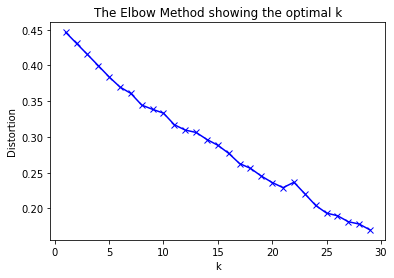

In [27]:
#Drop the neighborhood column (which we do not want to train our clusters to):
NOLA_grouped_clustering = NOLA_grouped.drop('Neighborhood', 1)

# k means determine k
distortions = []
K = range(1,30)
for k in K:
    kmeanModel = KMeans(n_clusters=k, random_state=0).fit(NOLA_grouped_clustering)
    distortions.append(sum(np.min(cdist(NOLA_grouped_clustering, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / NOLA_grouped_clustering.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

Unfortunately there is no apparent elbow in the above graph; the closest things to elbows occur at k = 8 and 12.  The lower value of k is less likely to overfit:

In [28]:
# set number of clusters
kclusters = 8

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(NOLA_grouped_clustering)

# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

neighborhoods_venues_sorted['Cluster Labels'] = neighborhoods_venues_sorted['Cluster Labels'].astype(int)

# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighborhood
NOLA_merged = df.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')
#NOLA_merged['Cluster Labels'] = NOLA_merged['Cluster Labels'].astype(int)

In [29]:
NOLA_merged.dropna(axis = 0, inplace=True)
NOLA_merged['Cluster Labels'] = NOLA_merged['Cluster Labels'].astype(int)

Remap the neighborhoods, colored according to their label from the k-means clustering algorithm:

In [30]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(NOLA_merged['Latitude'], NOLA_merged['Longitude'], NOLA_merged['Neighborhood'], NOLA_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

Several of the "clusters" consist of single neighborhoods, particularly those on the outskirts of the city.  It's not so surprising, for example, that the neighborhood "U.S. NAVAL BASE" belongs to a unique cluster.

A few interesting neighborhoods far from downtown end up in the same cluster as the French Quarter.  The Gentilly neighborhood ("GENTILLY TERRACE" and "MILNEBURG", and even "PINES VILLAGE") apparently cluster with the French Quarter, as do the more uptown neighborhoods "HOLLYGROVE" and "MARLYVILLE - FONTAINEBLEAU".

In [31]:
FQ_clust = NOLA_merged[NOLA_merged['Neighborhood'] == 'FRENCH QUARTER']['Cluster Labels'].iloc[0]
FQ_nbhds = NOLA_merged[NOLA_merged['Cluster Labels'] == FQ_clust]
FQ_nbhds

,Neighborhood,Longitude,Latitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
1,ALGIERS POINT,-90.051606,29.952462,0,Boat or Ferry,Bar,Historic Site
3,AUDUBON,-90.121450,29.932994,0,Sandwich Place,Plaza,Smoothie Shop
5,B. W. COOPER,-90.091753,29.951774,0,Gym / Fitness Center,Recreation Center,Boxing Gym
6,BAYOU ST. JOHN,-90.086517,29.976071,0,Convenience Store,Park,Playground
8,BLACK PEARL,-90.134883,29.935895,0,Food Truck,Plaza,Farmers Market
9,BROADMOOR,-90.103812,29.946568,0,Food Truck,Recreation Center,Coffee Shop
10,MARLYVILLE - FONTAINEBLEAU,-90.113468,29.953001,0,Bar,Campground,Nightclub
11,GERT TOWN,-90.105829,29.960289,0,Rental Service,Asian Restaurant,Financial or Legal Service
12,MID-CITY,-90.099392,29.970401,0,Hotel,Lounge,Pub
13,ST. CLAUDE,-90.039268,29.971814,0,Entertainment Service,Plaza,Park
